In [1]:
import random


random.seed(0)
truth_location_list = [[random.uniform(i[0], i[1]), random.uniform(j[0], j[1])] for i in [[0,2], [2,4], [4,6], [6,8], [8,10]] for j in [[0,2], [2,4], [4,6], [6,8], [8,10]] ]+ [[random.uniform(0,10), random.uniform(0,10)] for _ in range(75)]

estimated_accuracy_list = [1] * 25 + [0] * 75

estimate_location_list = [[0,0] for _ in range(100)]
for i in range(len(estimated_accuracy_list)):
    if estimated_accuracy_list[i] == 1:
        estimate_location_list[i] = truth_location_list[i]
    else:
        estimate_location_list[i] = [random.uniform(0,9), random.uniform(0,9)]


/var/folders/j4/pbwqtc3x6f964s_k6q48jskh0000gn/T/ipykernel_77068/900561130.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


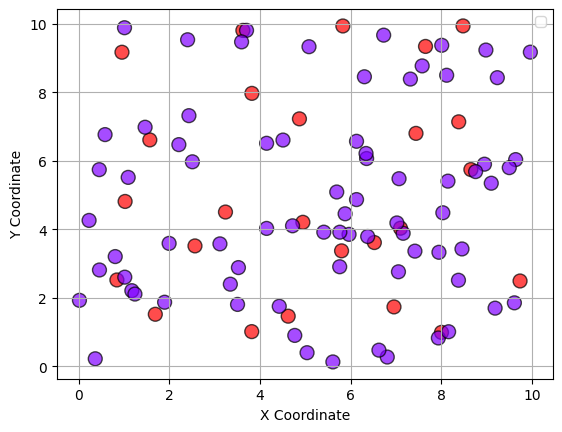

In [2]:

# visualize the nodes
import matplotlib.pyplot as plt
import numpy as np
# Extract x and y coordinates
truth_x, truth_y = zip(*truth_location_list)
estimate_x, estimate_y = zip(*estimate_location_list)

# Plot
plt.figure(facecolor='white')
scatter = plt.scatter(truth_x, truth_y, c=estimated_accuracy_list, cmap='rainbow', s=100, edgecolors='k', alpha=0.7)
# plt.scatter(truth_x, truth_y, color='black', marker='x', s=100, label='True Locations')

# plt.colorbar(scatter, label='Accuracy')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
# plt.title('Estimated vs True Locations with Accuracy as Color')
plt.legend()
plt.grid(True)
plt.show()

# squared

In [3]:
import random

truth_location_list_list = []
estimated_accuracy_list_list = []
estimate_location_list_list = []

random.seed(0)
for i in range(100):
    random.seed(i)
    truth_location_list = [[random.uniform(i[0], i[1]), random.uniform(j[0], j[1])] for i in [[0,2], [2,4], [4,6], [6,8], [8,10]] for j in [[0,2], [2,4], [4,6], [6,8], [8,10]] ]+ [[random.uniform(0,10), random.uniform(0,10)] for _ in range(75)]

    estimated_accuracy_list = [1] * 25 + [0] * 75

    estimate_location_list = [[0,0] for _ in range(100)]
    for i in range(len(estimated_accuracy_list)):
        if estimated_accuracy_list[i] == 1:
            estimate_location_list[i] = truth_location_list[i]
        else:
            estimate_location_list[i] = [random.uniform(0,9), random.uniform(0,9)]
    
    truth_location_list_list.append(truth_location_list)
    estimated_accuracy_list_list.append(estimated_accuracy_list)
    estimate_location_list_list.append(estimate_location_list)
    


In [4]:
import scipy.optimize as opt

# Multilateration function using least squares
def multilaterate(neighbors):
    def error_function(x, neighbors):
        return sum((np.linalg.norm(x - np.array(neighbor[0])) - neighbor[1])**2 for neighbor in neighbors)
    
    if len(neighbors) < 3:
        return None, None  # Not enough neighbors to perform multilateration
    
    initial_guess = np.mean([neighbor[0] for neighbor in neighbors], axis=0)
    result = opt.minimize(error_function, initial_guess, args=(neighbors,))
    
    if result.success:
        estimation_accuracy = 1 - np.sqrt(result.fun / len(neighbors))/np.mean([neighbor[1] for neighbor in neighbors])  # Root Mean Squared Error / Average Distance
        return result.x, estimation_accuracy
    else:
        return None, None

In [5]:
import imageio
import copy
from tqdm import tqdm
# prepare the lists

estimation_error_list = []

for j in tqdm(range(len(truth_location_list_list))):
    truth_location_list = truth_location_list_list[j]
    estimated_accuracy_list = estimated_accuracy_list_list[j]
    estimate_location_list = estimate_location_list_list[j]

    # Update estimate locations until accuracy is achieved
    iteration = 0

    max_error = 1
    noise_std_dev = 1  # Standard deviation of the noise to add to the distance
    estimation_error = []
    estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

    iteration += 1

    # Initialize history data structure
    neighbor_history = {i: {} for i in range(len(truth_location_list))}

    # while np.average(estimated_accuracy_list) < 1 and iteration <= 10:
    while iteration <= 10:
        estimate_location_list_old = copy.deepcopy(estimate_location_list)
        estimated_accuracy_list_old = copy.deepcopy(estimated_accuracy_list)
        for idx, node_location in enumerate(truth_location_list):

            if estimated_accuracy_list_old[idx] == 1:
                continue

            neighbor_list = [] # location, distance

            # find neighbors
            for i in range(len(truth_location_list)):
                if np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i])) <= 2 and node_location != truth_location_list[i]:
                    # only add neighbors that are accurate
                    if estimated_accuracy_list_old[i] >= 0.25:
                        distance = np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i]))
                        noisy_distance = distance + np.random.normal(0, noise_std_dev* (distance**2))  # Add noise to the distance
                        neighbor_list.append([estimate_location_list[i], noisy_distance])

                        # # Update history data
                        # if i not in neighbor_history[idx]:
                        #     neighbor_history[idx][i] = []
                        # neighbor_history[idx][i].append(noisy_distance)

                        # # Use history data to mitigate noise
                        # if len(neighbor_history[idx][i]) > 1:
                        #     avg_noisy_distance = np.mean(neighbor_history[idx][i])
                        #     neighbor_list.append((estimate_location_list[i], avg_noisy_distance, estimated_accuracy_list_old[i]))
                        # else:
                        #     neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))


                    # neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))
        
            # Calculate the location with multilateration
            new_location, estimation_accuracy = multilaterate(neighbor_list)
            if new_location is not None:
                estimate_location_list[idx] = new_location.tolist()
                # Calculate accuracy as the inverse of RSS (lower RSS means higher accuracy)
                estimated_accuracy_list[idx] = max(0, estimation_accuracy)

        # if estimate_location_list_old == estimate_location_list:
        #     break  # No updates, break the loop
        
        estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

        iteration += 1

        # print(estimate_location_list)
        # print(estimated_accuracy_list)
    
    estimation_error_list.append(estimation_error)


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


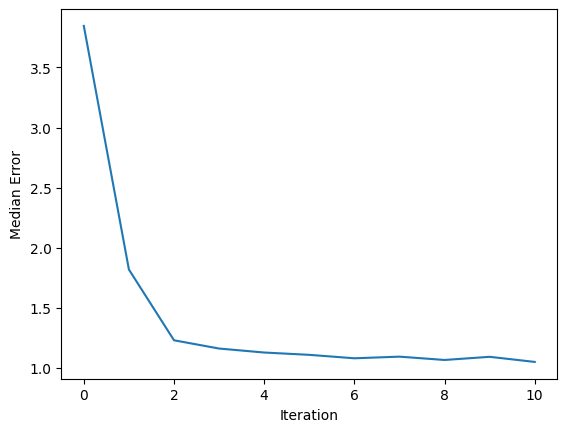

In [6]:
# for each list in estimation_error_list, calculate the median error and get the average of the median errors and show the plot
median_error_list = [np.median(i, axis=1) for i in estimation_error_list]
average_median_error = np.mean(median_error_list, axis=0)

plt.plot(average_median_error)
plt.xlabel('Iteration')
plt.ylabel('Median Error')
plt.show()


In [7]:
median_error_distance_squared = copy.deepcopy(average_median_error)

# history

In [11]:
import random

truth_location_list_list = []
estimated_accuracy_list_list = []
estimate_location_list_list = []

random.seed(0)
for i in range(100):
    random.seed(i)
    truth_location_list = [[random.uniform(i[0], i[1]), random.uniform(j[0], j[1])] for i in [[0,2], [2,4], [4,6], [6,8], [8,10]] for j in [[0,2], [2,4], [4,6], [6,8], [8,10]] ]+ [[random.uniform(0,10), random.uniform(0,10)] for _ in range(75)]

    estimated_accuracy_list = [1] * 25 + [0] * 75

    estimate_location_list = [[0,0] for _ in range(100)]
    for i in range(len(estimated_accuracy_list)):
        if estimated_accuracy_list[i] == 1:
            estimate_location_list[i] = truth_location_list[i]
        else:
            estimate_location_list[i] = [random.uniform(0,9), random.uniform(0,9)]
    
    truth_location_list_list.append(truth_location_list)
    estimated_accuracy_list_list.append(estimated_accuracy_list)
    estimate_location_list_list.append(estimate_location_list)
    

In [12]:
import scipy.optimize as opt

# Multilateration function using least squares
def multilaterate(neighbors):
    def error_function(x, neighbors):
        return sum((np.linalg.norm(x - np.array(neighbor[0])) - neighbor[1])**2 for neighbor in neighbors)
    
    if len(neighbors) < 3:
        return None, None  # Not enough neighbors to perform multilateration
    
    initial_guess = np.mean([neighbor[0] for neighbor in neighbors], axis=0)
    result = opt.minimize(error_function, initial_guess, args=(neighbors,))
    
    if result.success:
        estimation_accuracy = 1 - np.sqrt(result.fun / len(neighbors))/np.mean([neighbor[1] for neighbor in neighbors])  # Root Mean Squared Error / Average Distance
        return result.x, estimation_accuracy
    else:
        return None, None

In [13]:
import imageio
import copy
from tqdm import tqdm
# prepare the lists

estimation_error_list = []

for j in tqdm(range(len(truth_location_list_list))):
    truth_location_list = truth_location_list_list[j]
    estimated_accuracy_list = estimated_accuracy_list_list[j]
    estimate_location_list = estimate_location_list_list[j]

    # Update estimate locations until accuracy is achieved
    iteration = 0

    max_error = 1
    noise_std_dev = 0.3  # Standard deviation of the noise to add to the distance
    estimation_error = []
    estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

    iteration += 1

    # Initialize history data structure
    neighbor_history = {i: {} for i in range(len(truth_location_list))}

    # while np.average(estimated_accuracy_list) < 1 and iteration <= 10:
    while iteration <= 10:
        estimate_location_list_old = copy.deepcopy(estimate_location_list)
        estimated_accuracy_list_old = copy.deepcopy(estimated_accuracy_list)
        for idx, node_location in enumerate(truth_location_list):

            if estimated_accuracy_list_old[idx] == 1:
                continue

            neighbor_list = [] # location, distance

            # find neighbors
            for i in range(len(truth_location_list)):
                if np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i])) <= 2 and node_location != truth_location_list[i]:
                    # only add neighbors that are accurate
                    if estimated_accuracy_list_old[i] >= 0.25:
                        distance = np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i]))
                        noisy_distance = distance + np.random.normal(0, noise_std_dev* (distance**2))  # Add noise to the distance

                        # Update history data
                        if i not in neighbor_history[idx]:
                            neighbor_history[idx][i] = []
                        neighbor_history[idx][i].append(noisy_distance)

                        # Use history data to mitigate noise
                        if len(neighbor_history[idx][i]) > 1:
                            avg_noisy_distance = np.mean(neighbor_history[idx][i])
                            neighbor_list.append((estimate_location_list[i], avg_noisy_distance, estimated_accuracy_list_old[i]))
                        else:
                            neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))


            # Calculate the location with multilateration
            new_location, estimation_accuracy = multilaterate(neighbor_list)
            if new_location is not None:
                estimate_location_list[idx] = new_location.tolist()
                # Calculate accuracy as the inverse of RSS (lower RSS means higher accuracy)
                estimated_accuracy_list[idx] = max(0, estimation_accuracy)

        # if estimate_location_list_old == estimate_location_list:
        #     break  # No updates, break the loop
        
        estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

        iteration += 1

        # print(estimate_location_list)
        # print(estimated_accuracy_list)
    
    estimation_error_list.append(estimation_error)




100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


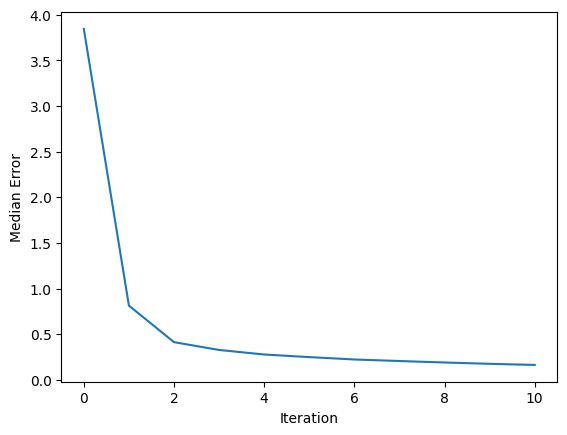

In [14]:
# for each list in estimation_error_list, calculate the median error and get the average of the median errors and show the plot
median_error_list = [np.median(i, axis=1) for i in estimation_error_list]
average_median_error = np.mean(median_error_list, axis=0)

plt.plot(average_median_error)
plt.xlabel('Iteration')
plt.ylabel('Median Error')
plt.show()


In [15]:
median_error_history = copy.deepcopy(average_median_error)

# weight

In [16]:
import random

truth_location_list_list = []
estimated_accuracy_list_list = []
estimate_location_list_list = []

random.seed(0)
for i in range(100):
    random.seed(i)
    truth_location_list = [[random.uniform(i[0], i[1]), random.uniform(j[0], j[1])] for i in [[0,2], [2,4], [4,6], [6,8], [8,10]] for j in [[0,2], [2,4], [4,6], [6,8], [8,10]] ]+ [[random.uniform(0,10), random.uniform(0,10)] for _ in range(75)]

    estimated_accuracy_list = [1] * 25 + [0] * 75

    estimate_location_list = [[0,0] for _ in range(100)]
    for i in range(len(estimated_accuracy_list)):
        if estimated_accuracy_list[i] == 1:
            estimate_location_list[i] = truth_location_list[i]
        else:
            estimate_location_list[i] = [random.uniform(0,9), random.uniform(0,9)]
    
    truth_location_list_list.append(truth_location_list)
    estimated_accuracy_list_list.append(estimated_accuracy_list)
    estimate_location_list_list.append(estimate_location_list)
    


In [17]:
def multilaterate(neighbors):
    def error_function(x, neighbors):
        return sum((neighbor[2]**2) * (np.linalg.norm(x - np.array(neighbor[0])) - neighbor[1])**2 for neighbor in neighbors)
    
    if len(neighbors) < 3:
        return None, None  # Not enough neighbors to perform multilateration
    
    initial_guess = np.mean([neighbor[0] for neighbor in neighbors], axis=0)
    result = opt.minimize(error_function, initial_guess, args=(neighbors,))
    
    if result.success:
        estimation_accuracy = 1 - np.sqrt(result.fun / len(neighbors)) / np.mean([neighbor[1] for neighbor in neighbors])  # Root Mean Squared Error / Average Distance
        return result.x, estimation_accuracy
    else:
        return None, None


In [18]:
import imageio
import copy
from tqdm import tqdm
# prepare the lists

estimation_error_list = []

for j in tqdm(range(len(truth_location_list_list))):
    truth_location_list = truth_location_list_list[j]
    estimated_accuracy_list = estimated_accuracy_list_list[j]
    estimate_location_list = estimate_location_list_list[j]

    # Update estimate locations until accuracy is achieved
    iteration = 0

    max_error = 1
    noise_std_dev = 0.3  # Standard deviation of the noise to add to the distance
    estimation_error = []
    estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

    iteration += 1

    # Initialize history data structure
    neighbor_history = {i: {} for i in range(len(truth_location_list))}

    # while np.average(estimated_accuracy_list) < 1 and iteration <= 10:
    while iteration <= 10:
        estimate_location_list_old = copy.deepcopy(estimate_location_list)
        estimated_accuracy_list_old = copy.deepcopy(estimated_accuracy_list)
        for idx, node_location in enumerate(truth_location_list):

            if estimated_accuracy_list_old[idx] == 1:
                continue

            neighbor_list = [] # location, distance

            # find neighbors
            for i in range(len(truth_location_list)):
                if np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i])) <= 2 and node_location != truth_location_list[i]:
                    # only add neighbors that are accurate
                    if estimated_accuracy_list_old[i] >= 0.25:
                        distance = np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i]))
                        noisy_distance = distance + np.random.normal(0, noise_std_dev* (distance**2))  # Add noise to the distance
                        neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))
                        
                        # # Update history data
                        # if i not in neighbor_history[idx]:
                        #     neighbor_history[idx][i] = []
                        # neighbor_history[idx][i].append(noisy_distance)

                        # # Use history data to mitigate noise
                        # if len(neighbor_history[idx][i]) > 1:
                        #     avg_noisy_distance = np.mean(neighbor_history[idx][i])
                        #     neighbor_list.append((estimate_location_list[i], avg_noisy_distance, estimated_accuracy_list_old[i]))
                        # else:
                        #     neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))


                    # neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))
        
            # Calculate the location with multilateration
            new_location, estimation_accuracy = multilaterate(neighbor_list)
            if new_location is not None:
                estimate_location_list[idx] = new_location.tolist()
                # Calculate accuracy as the inverse of RSS (lower RSS means higher accuracy)
                estimated_accuracy_list[idx] = max(0, estimation_accuracy)

        # if estimate_location_list_old == estimate_location_list:
        #     break  # No updates, break the loop
        
        estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

        iteration += 1

        # print(estimate_location_list)
        # print(estimated_accuracy_list)
    
    estimation_error_list.append(estimation_error)


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


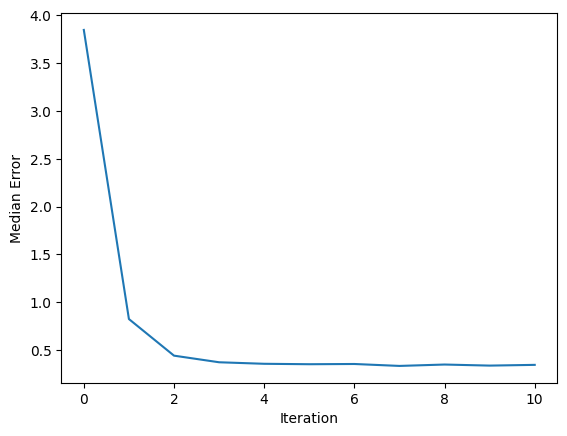

In [19]:
# for each list in estimation_error_list, calculate the median error and get the average of the median errors and show the plot
median_error_list = [np.median(i, axis=1) for i in estimation_error_list]
average_median_error = np.mean(median_error_list, axis=0)

plt.plot(average_median_error)
plt.xlabel('Iteration')
plt.ylabel('Median Error')
plt.show()


In [20]:
median_error_weight = copy.deepcopy(average_median_error)

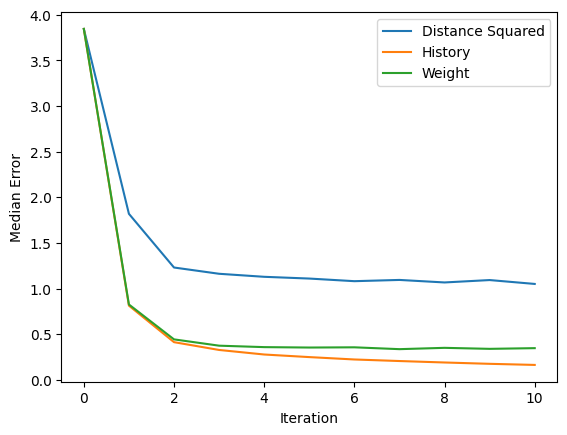

In [21]:
plt.plot(median_error_distance_squared, label='Distance Squared')
plt.plot(median_error_history, label='History')
plt.plot(median_error_weight, label='Weight')
plt.xlabel('Iteration')
plt.ylabel('Median Error')
plt.legend()
plt.show()

# 足切り

## top 5 closest neighbor

In [24]:
import random

truth_location_list_list = []
estimated_accuracy_list_list = []
estimate_location_list_list = []

random.seed(0)
for i in range(100):
    random.seed(i)
    truth_location_list = [[random.uniform(i[0], i[1]), random.uniform(j[0], j[1])] for i in [[0,2], [2,4], [4,6], [6,8], [8,10]] for j in [[0,2], [2,4], [4,6], [6,8], [8,10]] ]+ [[random.uniform(0,10), random.uniform(0,10)] for _ in range(75)]

    estimated_accuracy_list = [1] * 25 + [0] * 75

    estimate_location_list = [[0,0] for _ in range(100)]
    for i in range(len(estimated_accuracy_list)):
        if estimated_accuracy_list[i] == 1:
            estimate_location_list[i] = truth_location_list[i]
        else:
            estimate_location_list[i] = [random.uniform(0,9), random.uniform(0,9)]
    
    truth_location_list_list.append(truth_location_list)
    estimated_accuracy_list_list.append(estimated_accuracy_list)
    estimate_location_list_list.append(estimate_location_list)
    


In [25]:
import scipy.optimize as opt

# Multilateration function using least squares
def multilaterate(neighbors):
    def error_function(x, neighbors):
        return sum((np.linalg.norm(x - np.array(neighbor[0])) - neighbor[1])**2 for neighbor in neighbors)
    
    if len(neighbors) < 3:
        return None, None  # Not enough neighbors to perform multilateration
    
    initial_guess = np.mean([neighbor[0] for neighbor in neighbors], axis=0)
    result = opt.minimize(error_function, initial_guess, args=(neighbors,))
    
    if result.success:
        estimation_accuracy = 1 - np.sqrt(result.fun / len(neighbors))/np.mean([neighbor[1] for neighbor in neighbors])  # Root Mean Squared Error / Average Distance
        return result.x, estimation_accuracy
    else:
        return None, None

In [26]:
import imageio
import copy
from tqdm import tqdm
# prepare the lists

estimation_error_list = []

for j in tqdm(range(len(truth_location_list_list))):
    truth_location_list = truth_location_list_list[j]
    estimated_accuracy_list = estimated_accuracy_list_list[j]
    estimate_location_list = estimate_location_list_list[j]

    # Update estimate locations until accuracy is achieved
    iteration = 0

    max_error = 1
    noise_std_dev = 1  # Standard deviation of the noise to add to the distance
    estimation_error = []
    estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

    iteration += 1

    # Initialize history data structure
    neighbor_history = {i: {} for i in range(len(truth_location_list))}

    # while np.average(estimated_accuracy_list) < 1 and iteration <= 10:
    while iteration <= 10:
        estimate_location_list_old = copy.deepcopy(estimate_location_list)
        estimated_accuracy_list_old = copy.deepcopy(estimated_accuracy_list)
        for idx, node_location in enumerate(truth_location_list):

            if estimated_accuracy_list_old[idx] == 1:
                continue

            neighbor_list = [] # location, distance

            # find neighbors
            for i in range(len(truth_location_list)):
                if np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i])) <= 2 and node_location != truth_location_list[i]:
                # if node_location != truth_location_list[i]:
                    # only add neighbors that are accurate
                    if estimated_accuracy_list_old[i] >= 0.25:
                        distance = np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i]))
                        noisy_distance = distance + np.random.normal(0, noise_std_dev* (distance**2))  # Add noise to the distance
                        neighbor_list.append([estimate_location_list[i], noisy_distance])
                        

                        # # Update history data
                        # if i not in neighbor_history[idx]:
                        #     neighbor_history[idx][i] = []
                        # neighbor_history[idx][i].append(noisy_distance)

                        # # Use history data to mitigate noise
                        # if len(neighbor_history[idx][i]) > 1:
                        #     avg_noisy_distance = np.mean(neighbor_history[idx][i])
                        #     neighbor_list.append((estimate_location_list[i], avg_noisy_distance, estimated_accuracy_list_old[i]))
                        # else:
                        #     neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))


                    # neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))
        
            # take the top 5 closest neighbors if there are more than 5 neighbors
            neighbor_list = sorted(neighbor_list, key=lambda x: x[1])[:5]
            
            # Calculate the location with multilateration
            new_location, estimation_accuracy = multilaterate(neighbor_list)
            if new_location is not None:
                estimate_location_list[idx] = new_location.tolist()
                # Calculate accuracy as the inverse of RSS (lower RSS means higher accuracy)
                estimated_accuracy_list[idx] = max(0, estimation_accuracy)
            
        # if estimate_location_list_old == estimate_location_list:
        #     break  # No updates, break the loop
        
        estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

        iteration += 1

        # print(estimate_location_list)
        # print(estimated_accuracy_list)
    
    estimation_error_list.append(estimation_error)


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


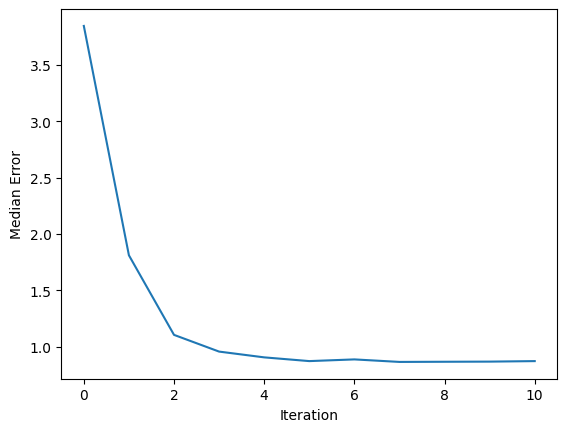

In [27]:
# for each list in estimation_error_list, calculate the median error and get the average of the median errors and show the plot
median_error_list = [np.median(i, axis=1) for i in estimation_error_list]
average_median_error = np.mean(median_error_list, axis=0)

plt.plot(average_median_error)
plt.xlabel('Iteration')
plt.ylabel('Median Error')
plt.show()


In [28]:
median_top_5_neighbor = copy.deepcopy(average_median_error)

## top10

In [162]:
import random

truth_location_list_list = []
estimated_accuracy_list_list = []
estimate_location_list_list = []

random.seed(0)
for i in range(100):
    random.seed(i)
    truth_location_list = [[random.uniform(i[0], i[1]), random.uniform(j[0], j[1])] for i in [[0,2], [2,4], [4,6], [6,8], [8,10]] for j in [[0,2], [2,4], [4,6], [6,8], [8,10]] ]+ [[random.uniform(0,10), random.uniform(0,10)] for _ in range(75)]

    estimated_accuracy_list = [1] * 25 + [0] * 75

    estimate_location_list = [[0,0] for _ in range(100)]
    for i in range(len(estimated_accuracy_list)):
        if estimated_accuracy_list[i] == 1:
            estimate_location_list[i] = truth_location_list[i]
        else:
            estimate_location_list[i] = [random.uniform(0,9), random.uniform(0,9)]
    
    truth_location_list_list.append(truth_location_list)
    estimated_accuracy_list_list.append(estimated_accuracy_list)
    estimate_location_list_list.append(estimate_location_list)
    


In [163]:
import scipy.optimize as opt

# Multilateration function using least squares
def multilaterate(neighbors):
    def error_function(x, neighbors):
        return sum((np.linalg.norm(x - np.array(neighbor[0])) - neighbor[1])**2 for neighbor in neighbors)
    
    if len(neighbors) < 3:
        return None, None  # Not enough neighbors to perform multilateration
    
    initial_guess = np.mean([neighbor[0] for neighbor in neighbors], axis=0)
    result = opt.minimize(error_function, initial_guess, args=(neighbors,))
    
    if result.success:
        estimation_accuracy = 1 - np.sqrt(result.fun / len(neighbors))/np.mean([neighbor[1] for neighbor in neighbors])  # Root Mean Squared Error / Average Distance
        return result.x, estimation_accuracy
    else:
        return None, None

In [164]:
import imageio
import copy
from tqdm import tqdm
# prepare the lists

estimation_error_list = []
for i in tqdm(range(len(truth_location_list_list))):
    truth_location_list = truth_location_list_list[i]
    estimated_accuracy_list = estimated_accuracy_list_list[i]
    estimate_location_list = estimate_location_list_list[i]

    # Update estimate locations until accuracy is achieved
    iteration = 0

    max_error = 1
    noise_std_dev = 0.3  # Standard deviation of the noise to add to the distance
    estimation_error = []
    estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

    iteration += 1

    # Initialize history data structure
    neighbor_history = {i: {} for i in range(len(truth_location_list))}

    # while np.average(estimated_accuracy_list) < 1 and iteration <= 10:
    while iteration <= 10:
        estimate_location_list_old = copy.deepcopy(estimate_location_list)
        estimated_accuracy_list_old = copy.deepcopy(estimated_accuracy_list)
        for idx, node_location in enumerate(truth_location_list):

            if estimated_accuracy_list_old[idx] == 1:
                continue

            neighbor_list = [] # location, distance

            # find neighbors
            for i in range(len(truth_location_list)):
                if np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i])) <= 2 and node_location != truth_location_list[i]:
                # if node_location != truth_location_list[i]:
                    # only add neighbors that are accurate
                    if estimated_accuracy_list_old[i] >= 0.25:
                        distance = np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i]))
                        noisy_distance = distance + np.random.normal(0, noise_std_dev* (distance**2))  # Add noise to the distance
                        neighbor_list.append([estimate_location_list[i], noisy_distance])
                        

                        # # Update history data
                        # if i not in neighbor_history[idx]:
                        #     neighbor_history[idx][i] = []
                        # neighbor_history[idx][i].append(noisy_distance)

                        # # Use history data to mitigate noise
                        # if len(neighbor_history[idx][i]) > 1:
                        #     avg_noisy_distance = np.mean(neighbor_history[idx][i])
                        #     neighbor_list.append((estimate_location_list[i], avg_noisy_distance, estimated_accuracy_list_old[i]))
                        # else:
                        #     neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))


                    # neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))
        
            # take the top 5 closest neighbors if there are more than 5 neighbors
            neighbor_list = sorted(neighbor_list, key=lambda x: x[1])[:10]
            
            # Calculate the location with multilateration
            new_location, estimation_accuracy = multilaterate(neighbor_list)
            if new_location is not None:
                estimate_location_list[idx] = new_location.tolist()
                # Calculate accuracy as the inverse of RSS (lower RSS means higher accuracy)
                estimated_accuracy_list[idx] = max(0, estimation_accuracy)
            
        # if estimate_location_list_old == estimate_location_list:
        #     break  # No updates, break the loop
        
        estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

        iteration += 1

        # print(estimate_location_list)
        # print(estimated_accuracy_list)
    
    estimation_error_list.append(estimation_error)


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


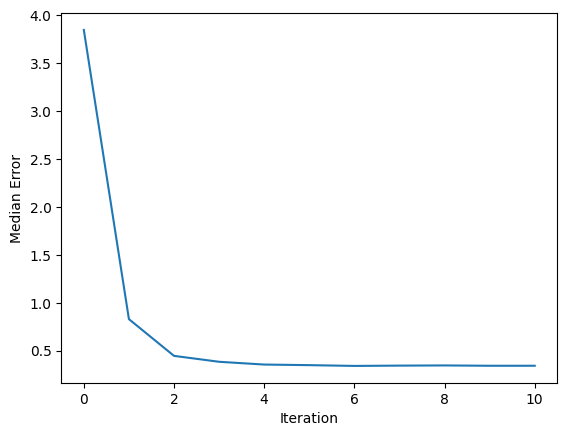

In [165]:
# for each list in estimation_error_list, calculate the median error and get the average of the median errors and show the plot
median_error_list = [np.median(i, axis=1) for i in estimation_error_list]
average_median_error = np.mean(median_error_list, axis=0)

plt.plot(average_median_error)
plt.xlabel('Iteration')
plt.ylabel('Median Error')
plt.show()


In [166]:
median_top_10_neighbor = copy.deepcopy(average_median_error)

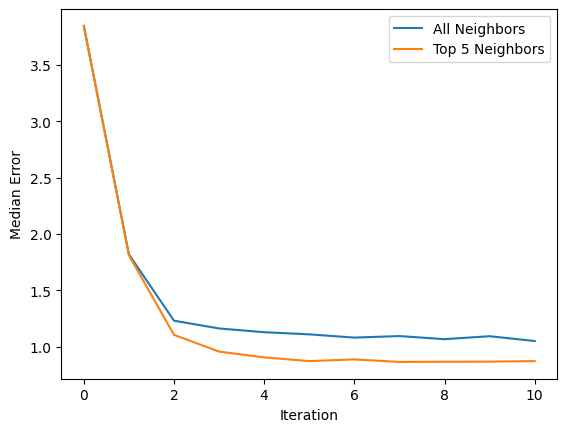

In [29]:
plt.plot(median_error_distance_squared, label='All Neighbors')
# plt.plot(median_error_history, label='History')
# plt.plot(median_error_weight, label='Weight')
plt.plot(median_top_5_neighbor, label='Top 5 Neighbors')
# plt.plot(median_top_10_neighbor, label='Top 10 Neighbor')
plt.xlabel('Iteration')
plt.ylabel('Median Error')
plt.legend()
plt.show()

In [187]:
print(np.average(neighbor_num_list))
print(np.max(neighbor_num_list))
print(np.median(neighbor_num_list))

8.235453333333334
24
8.0


## check all combination of neighbors

In [59]:
import random

truth_location_list_list = []
estimated_accuracy_list_list = []
estimate_location_list_list = []

random.seed(0)
for i in range(100):
    random.seed(i)
    truth_location_list = [[random.uniform(i[0], i[1]), random.uniform(j[0], j[1])] for i in [[0,2], [2,4], [4,6], [6,8], [8,10]] for j in [[0,2], [2,4], [4,6], [6,8], [8,10]] ]+ [[random.uniform(0,10), random.uniform(0,10)] for _ in range(75)]

    estimated_accuracy_list = [1] * 25 + [0] * 75

    estimate_location_list = [[0,0] for _ in range(100)]
    for i in range(len(estimated_accuracy_list)):
        if estimated_accuracy_list[i] == 1:
            estimate_location_list[i] = truth_location_list[i]
        else:
            estimate_location_list[i] = [random.uniform(0,9), random.uniform(0,9)]
    
    truth_location_list_list.append(truth_location_list)
    estimated_accuracy_list_list.append(estimated_accuracy_list)
    estimate_location_list_list.append(estimate_location_list)
    


In [60]:
import scipy.optimize as opt

# Multilateration function using least squares
def multilaterate(neighbors):
    def error_function(x, neighbors):
        return sum((np.linalg.norm(x - np.array(neighbor[0])) - neighbor[1])**2 for neighbor in neighbors)
    
    if len(neighbors) < 3:
        return None, None  # Not enough neighbors to perform multilateration
    
    initial_guess = np.mean([neighbor[0] for neighbor in neighbors], axis=0)
    result = opt.minimize(error_function, initial_guess, args=(neighbors,))
    
    if result.success:
        estimation_accuracy = 1 - np.sqrt(result.fun / len(neighbors))/np.mean([neighbor[1] for neighbor in neighbors])  # Root Mean Squared Error / Average Distance
        return result.x, estimation_accuracy, np.sqrt(result.fun / len(neighbors))
    else:
        return None, None, None

In [61]:
import imageio
import copy
from tqdm import tqdm
# prepare the lists

accuracy_and_rmse_list = []

estimation_error_list = []
for j in tqdm(range(len(truth_location_list_list))):
    truth_location_list = truth_location_list_list[j]
    estimated_accuracy_list = estimated_accuracy_list_list[j]
    estimate_location_list = estimate_location_list_list[j]

    # Update estimate locations until accuracy is achieved
    iteration = 0

    max_error = 1
    noise_std_dev = 1  # Standard deviation of the noise to add to the distance
    estimation_error = []
    estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

    iteration += 1

    # Initialize history data structure
    neighbor_history = {i: {} for i in range(len(truth_location_list))}

    # while np.average(estimated_accuracy_list) < 1 and iteration <= 10:
    while iteration <= 10:
        estimate_location_list_old = copy.deepcopy(estimate_location_list)
        estimated_accuracy_list_old = copy.deepcopy(estimated_accuracy_list)
        for idx, node_location in enumerate(truth_location_list):

            if estimated_accuracy_list_old[idx] == 1:
                continue

            neighbor_list = [] # location, distance

            # find neighbors
            for i in range(len(truth_location_list)):
                if np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i])) <= 2 and node_location != truth_location_list[i]:
                # if node_location != truth_location_list[i]:
                    # only add neighbors that are accurate
                    if estimated_accuracy_list_old[i] >= 0.25:
                        distance = np.linalg.norm(np.array(node_location) - np.array(truth_location_list[i]))
                        noisy_distance = distance + np.random.normal(0, noise_std_dev* (distance**2))  # Add noise to the distance
                        neighbor_list.append([estimate_location_list[i], noisy_distance])
                        

                        # # Update history data
                        # if i not in neighbor_history[idx]:
                        #     neighbor_history[idx][i] = []
                        # neighbor_history[idx][i].append(noisy_distance)

                        # # Use history data to mitigate noise
                        # if len(neighbor_history[idx][i]) > 1:
                        #     avg_noisy_distance = np.mean(neighbor_history[idx][i])
                        #     neighbor_list.append((estimate_location_list[i], avg_noisy_distance, estimated_accuracy_list_old[i]))
                        # else:
                        #     neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))


                    # neighbor_list.append((estimate_location_list[i], noisy_distance, estimated_accuracy_list_old[i]))
        
            # take the top 5 closest neighbors if there are more than 5 neighbors
            neighbor_list = sorted(neighbor_list, key=lambda x: x[1])

            min_rmse = 10**9
            for i in range(3, len(neighbor_list)):
                neighbor_list_subset = neighbor_list[:i]
            
                # Calculate the location with multilateration
                new_location, estimation_accuracy, rmse = multilaterate(neighbor_list)
                if new_location is not None:
                    accuracy_and_rmse_list.append((np.linalg.norm(np.array(new_location)-np.array(node_location)), rmse, idx))
                if new_location is not None and rmse < min_rmse:
                    estimate_location_list[idx] = new_location.tolist()
                    # Calculate accuracy as the inverse of RSS (lower RSS means higher accuracy)
                    estimated_accuracy_list[idx] = max(0, estimation_accuracy)
            
        # if estimate_location_list_old == estimate_location_list:
        #     break  # No updates, break the loop
        
        estimation_error.append(list(np.linalg.norm(np.array(estimate_location_list[i]) - np.array(truth_location_list[i])) for i in range(len(truth_location_list))))

        iteration += 1

        # print(estimate_location_list)
        # print(estimated_accuracy_list)
    
    estimation_error_list.append(estimation_error)


100%|██████████| 100/100 [03:42<00:00,  2.22s/it]


In [76]:
# how many idx in accuracy_and_rmse_list
print(len(accuracy_and_rmse_list))


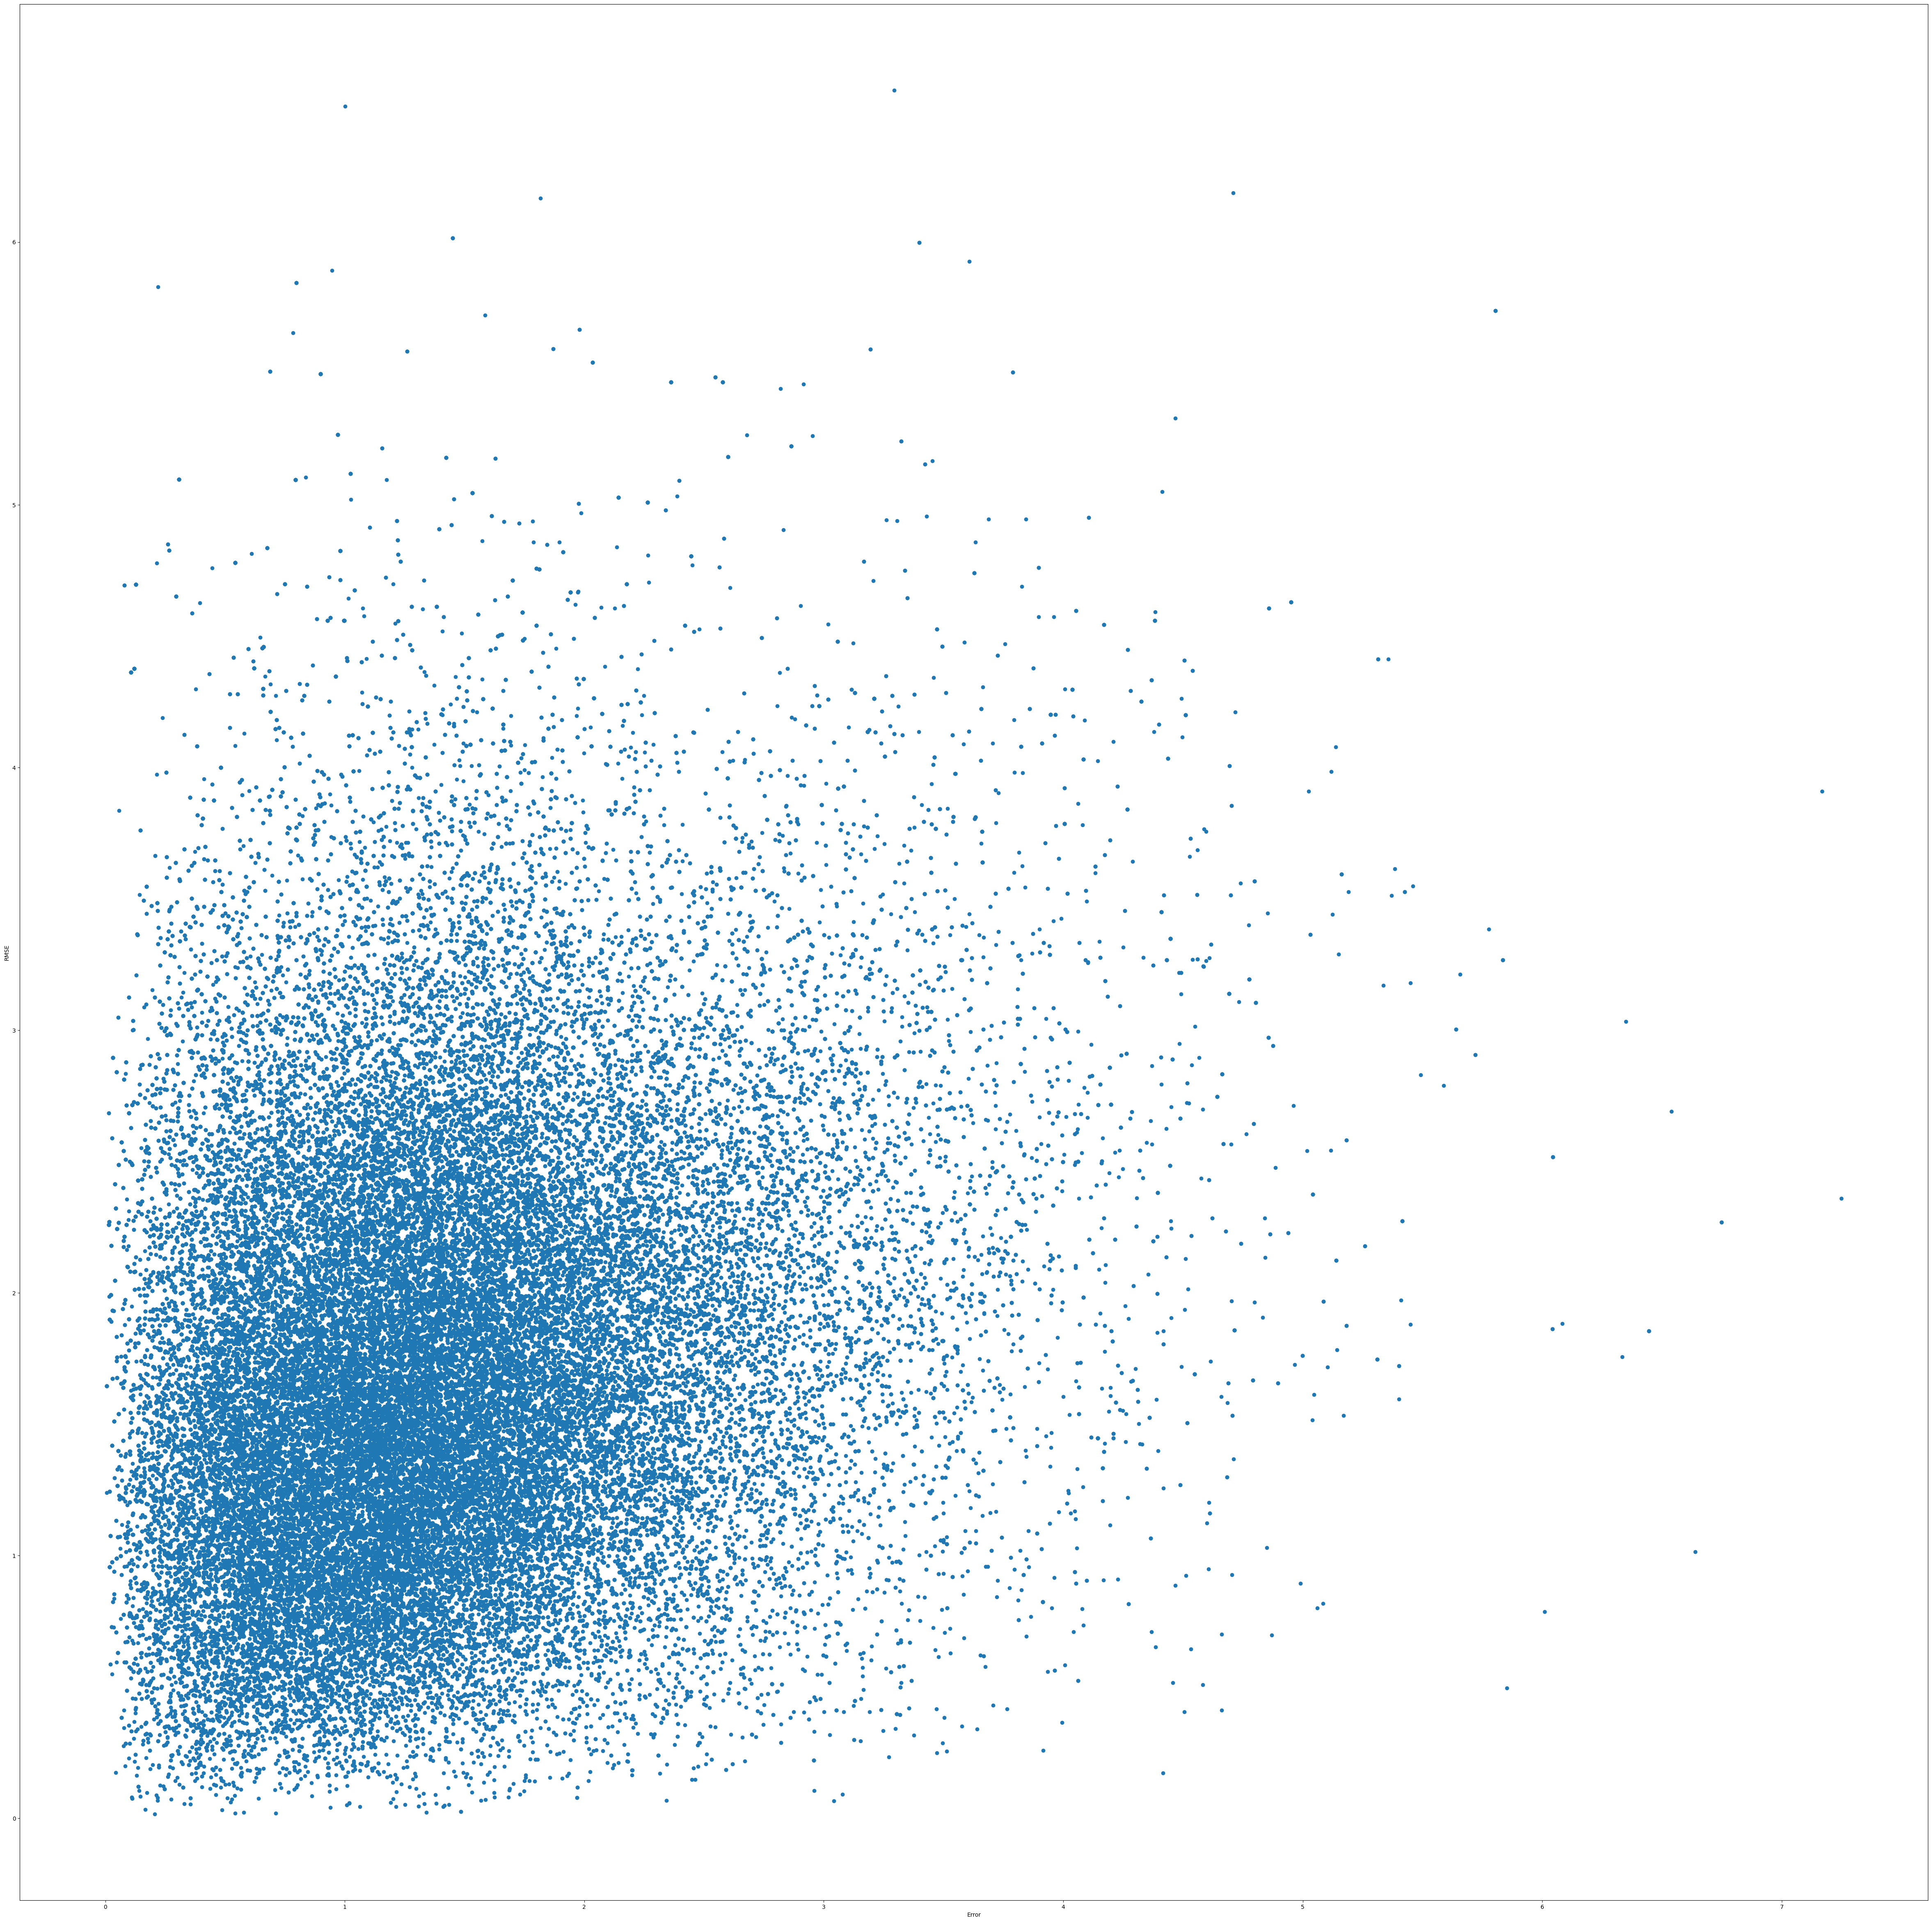

In [91]:
# graph for accuracy and rmse with different color for each idx
import matplotlib.pyplot as plt
import numpy as np

accuracy_and_rmse_list = np.array(accuracy_and_rmse_list)
# graph size
plt.figure(figsize=(60, 60))
plt.scatter(accuracy_and_rmse_list[:,0], accuracy_and_rmse_list[:,1])
plt.xlabel('Error')
plt.ylabel('RMSE')
plt.show()


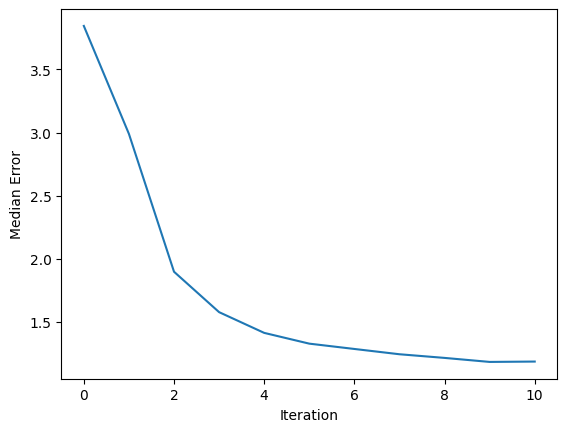

In [33]:
# for each list in estimation_error_list, calculate the median error and get the average of the median errors and show the plot
median_error_list = [np.median(i, axis=1) for i in estimation_error_list]
average_median_error = np.mean(median_error_list, axis=0)

plt.plot(average_median_error)
plt.xlabel('Iteration')
plt.ylabel('Median Error')
plt.show()


In [34]:
median_best_neighbor_num = copy.deepcopy(average_median_error)

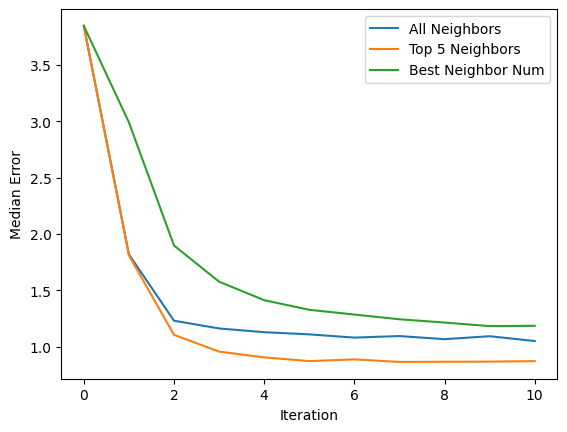

In [35]:
plt.plot(median_error_distance_squared, label='All Neighbors')
plt.plot(median_top_5_neighbor, label='Top 5 Neighbors')
plt.plot(median_best_neighbor_num, label='Best Neighbor Num')
plt.xlabel('Iteration')
plt.ylabel('Median Error')
plt.legend()
plt.show()